# Classification des critiques des documents

#### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
%config IPCompleter.greedy = True
%matplotlib inline

In [2]:
data = pd.read_csv('./table_dataset.csv', delimiter=';')
df = data[['text', 'interest_table']]

df.head()

,text,interest_table
0,MARK NO. QTY SIZE SERIES FACING TYPE MIN. HOLE...,1
1,CONFIDENTIAL THIS DRAWING IS THE SOLE PROPERTY...,0
2,TAM. RVVess ff UVRVoOLU Part Numbers FIND y...,1
3,cen a a a ec ll Ml A aca sia seca Part Numbe...,1
4,Part Numbers DESCRIPTION | QTY|(*) spare pars...,1


### Proportion des valeurs

In [3]:
df['interest_table'].value_counts()

interest_table
0    601
1    147
Name: count, dtype: int64

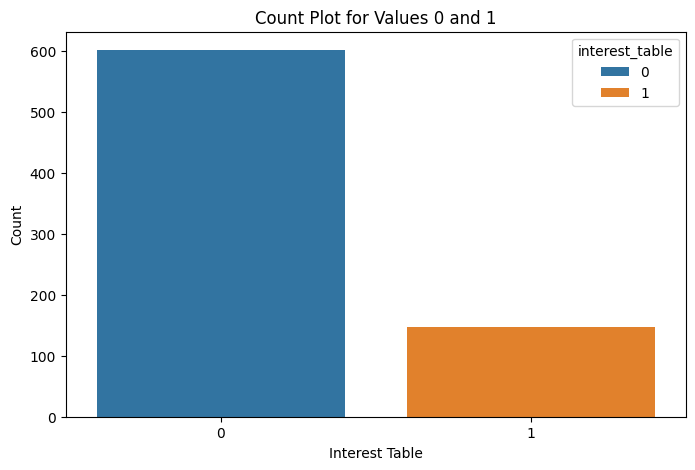

In [4]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='interest_table', hue='interest_table')

# Set labels and title
plt.xlabel('Interest Table')
plt.ylabel('Count')
plt.title('Count Plot for Values 0 and 1')

# Show the plot
plt.show()

## Data cleaning

In [5]:
# nltk.download('stopwords')
# nltk.download('popular')

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import pandas as pd

def cleaning_pdf_interest(df, col_name):
    porter = PorterStemmer()
    stop_words = set(stopwords.words())

    def clean_text(text):
        text = str(text)
        text = text.lower()
        text = re.sub('(<.*?>)|(\n)|([^\w\s\.\,])|([_])|([.])|([,])|(\s\s+)|([ا-ي])', '', text)
        cleaned_text = ' '.join([porter.stem(i) for i in word_tokenize(text) if i not in stop_words])
        return cleaned_text

    cleaned_column = df[col_name].apply(clean_text)
    
    return cleaned_column


* Chaque mot est transformer en miniscule avec lower.
* on utilise une expression reguliere pour remplacer  : les balise html, les retour a la ligne, les caractere spéciaux qui ne sont pas des point ou des virgule  (par exemple, !, ?, :) ,les underscore, les points, les virgules, les espace multiple et les mots non anglais par un espace vide
* chaque mot qui n'est pas un stop_word (and, or, but, etc) est tokenizer et on retour sa basse (ex : terreste devient terre)


In [7]:
df['text'] = cleaning_pdf_interest(df,'text')

In [8]:
df['text'][:5]

0    mark qti size seri face type hole id neckservi...
1    confidenti draw sole properti peerlessmfg comp...
2    tam rvvess ff uvrvoolupart numbersfindy descri...
3    cen ec ml acasia secapart numbersfindy descrip...
4    part numbersdescript qti spare par recommended...
Name: text, dtype: object

## Split train and test

In [9]:
# pip install scikit-learn

In [10]:
from sklearn.model_selection import train_test_split
X = df['text'].tolist()
y = df['interest_table'].tolist()
y = [int(x) for x in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Vectorisation 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(stop_words='english', max_features=None, max_df=0.5, min_df=2, ngram_range=(1,1))

X_train = tfidf_vector.fit_transform(X_train)
X_test = tfidf_vector.transform(X_test)

## Model

## 1- Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


In [13]:
lr = LogisticRegression(random_state=42)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       181
           1       1.00      0.43      0.60        44

    accuracy                           0.89       225
   macro avg       0.94      0.72      0.77       225
weighted avg       0.90      0.89      0.87       225



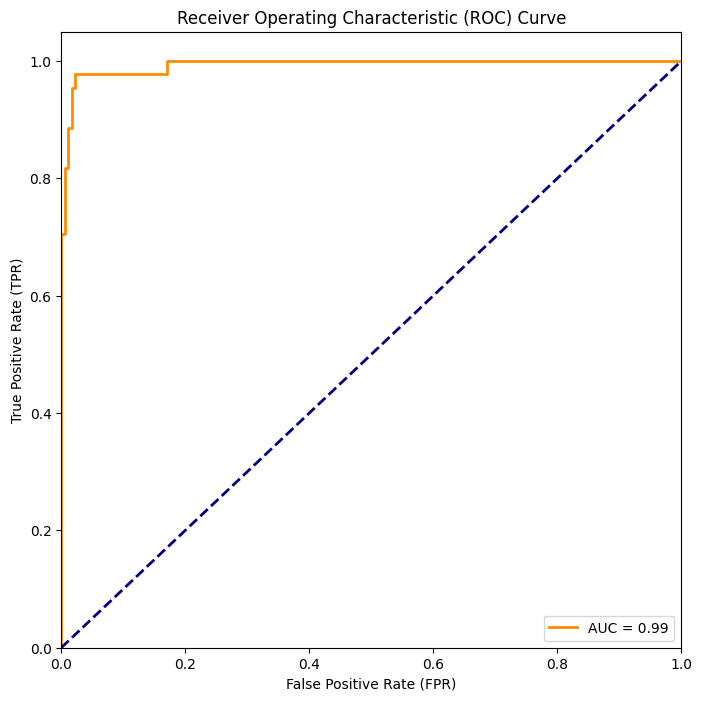

In [14]:
y_prob = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
coef_abs = abs(lr.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
lr_best_index = feature_scores[:10].index
for index in lr_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 2074 : {'pospart'}
 feature : 2021 : {'pc'}
 feature : 2014 : {'pagina'}
 feature : 1985 : {'number'}
 feature : 1657 : {'gener'}
 feature : 1208 : {'approv'}
 feature : 1559 : {'engineproduct'}
 feature : 1400 : {'cpage'}
 feature : 1444 : {'dbad308632'}
 feature : 213 : {'135'}


## 2-Random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
rf = RandomForestClassifier(min_samples_split=5 ,max_depth=10, random_state=42)
rf = rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       181
           1       1.00      0.59      0.74        44

    accuracy                           0.92       225
   macro avg       0.95      0.80      0.85       225
weighted avg       0.93      0.92      0.91       225



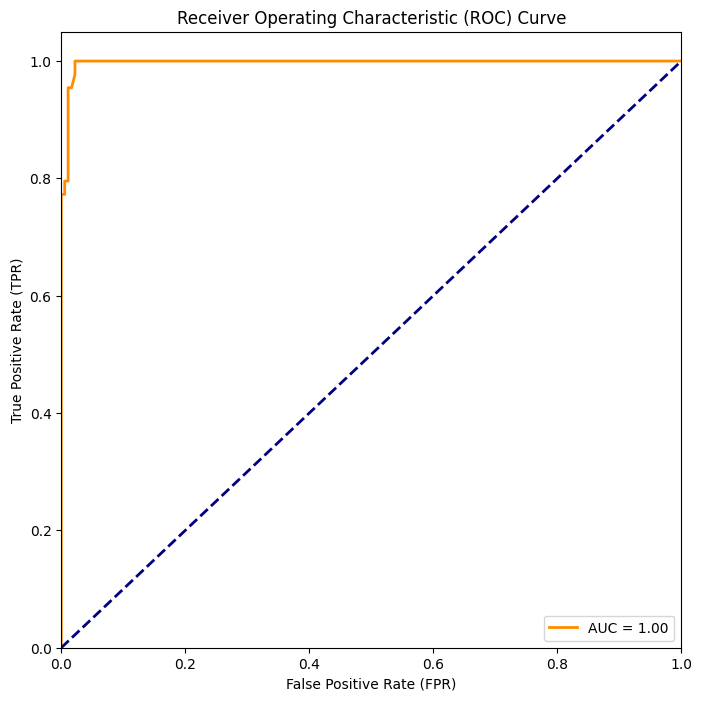

In [19]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
feature_scores = pd.Series(rf.feature_importances_).sort_values(ascending=False)
rf_best_index = feature_scores[:10].index
for index in rf_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 2074 : {'pospart'}
 feature : 2063 : {'pn'}
 feature : 14 : {'001'}
 feature : 1501 : {'dwg'}
 feature : 1119 : {'a043u624'}
 feature : 1449 : {'descript'}
 feature : 2470 : {'u3e3cuueini'}
 feature : 2005 : {'ore'}
 feature : 2064 : {'po'}
 feature : 1851 : {'list'}


## 3-LinearSV

In [21]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42)
svm = svm.fit(X_train, y_train)
y_pred3 = svm.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       181
           1       1.00      0.80      0.89        44

    accuracy                           0.96       225
   macro avg       0.98      0.90      0.93       225
weighted avg       0.96      0.96      0.96       225



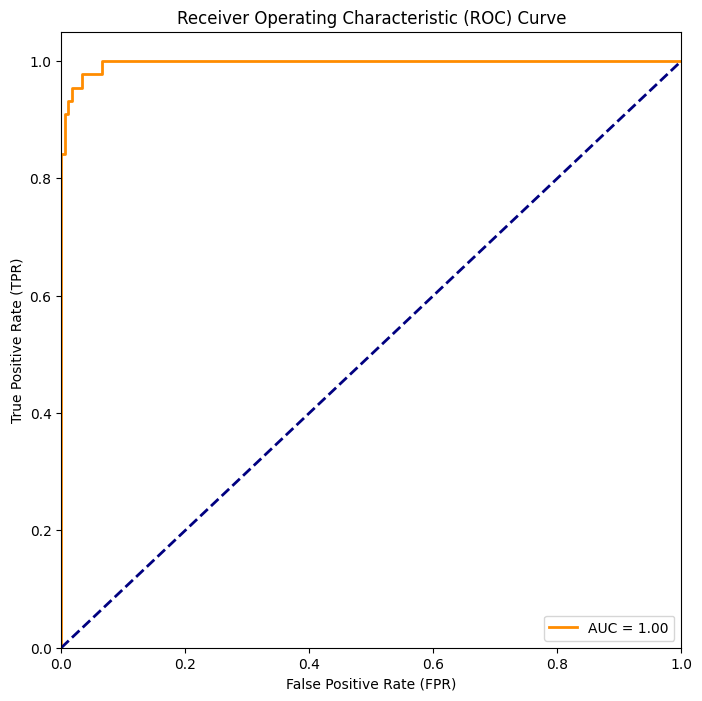

In [22]:
y_scores = svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
coef_abs = abs(svm.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
svm_best_index = feature_scores[:10].index


for index in svm_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 2074 : {'pospart'}
 feature : 2014 : {'pagina'}
 feature : 213 : {'135'}
 feature : 2125 : {'radiat'}
 feature : 1657 : {'gener'}
 feature : 1953 : {'nan'}
 feature : 1909 : {'measur'}
 feature : 217 : {'135pagina'}
 feature : 1208 : {'approv'}
 feature : 1985 : {'number'}


## sauvegarde des models 

In [34]:
import os
os.listdir()

['data_classifaction.ipynb',
 'data_classifaiction.py',
 'lr_model.joblib',
 'lr_model.pk',
 'npl_data_classifaction.ipynb',
 'rf_model.pkl',
 'svm_model.pkl',
 'table_dataset.csv']

In [28]:
import joblib

joblib.dump(lr, 'lr_model.pk')
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(svm, 'svm_model.pkl')


['svm_model.pkl']

In [29]:
lr_model = joblib.load('lr_model.pk')
lr_model = joblib.load('rf_model.pkl')
svm_model = joblib.load('svm_model.pkl')

# Test sur les données non annotées

In [30]:
pred = lr_model.predict(X_test)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0])